# Author Disambiguation by Classification Approach

## Author: Mitodru Niyogi

In [23]:
import os
import xml.etree.ElementTree as ET
import re
import pandas as pd
import  matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from src.preprocess import load_data_csv, transform_data, clean_text, preprocess_dataset
from src.models import get_ml_models
from src.batch_score import batch_prediction
from src.evaluate import evaluate_model_predict

# Define the directory path containing the A++ files
#dir_path = '/path/to/folder/containing/xml/files'
dir_path = '../test-articles/'

In [1]:
from src.preprocess import extract_article_title_xml

In [2]:
# load dataset for authors
df_all = load_data_csv(dir_path+'authors.csv', delimiter=',')

In [3]:
df_all.head()

,Author,ArticleID,Article Title,Journal Title,Journal Subject,Affiliations
0,Patrick T. Ronaldson,10.1023/B:PHAM.0000026433.27773.47,Involvement of P-Glycoprotein in the Transport...,Pharmaceutical Research,Biomedicine,"Department of Pharmaceutical Sciences, Leslie ..."
1,Gloria Lee,10.1023/B:PHAM.0000026433.27773.47,Involvement of P-Glycoprotein in the Transport...,Pharmaceutical Research,Biomedicine,"Department of Pharmaceutical Sciences, Leslie ..."
2,Gloria Lee,10.1023/B:PHAM.0000036905.82914.8e,Functional Expression and Localization of P-gl...,Pharmaceutical Research,Biomedicine,Laboratoire de Biophysique des Matériaux Alime...
3,Shannon Dallas,10.1023/B:PHAM.0000026433.27773.47,Involvement of P-Glycoprotein in the Transport...,Pharmaceutical Research,Biomedicine,"Department of Pharmaceutical Sciences, Leslie ..."
4,Reina Bendayan,10.1023/B:PHAM.0000026433.27773.47,Involvement of P-Glycoprotein in the Transport...,Pharmaceutical Research,Biomedicine,"Department of Pharmaceutical Sciences, Leslie ..."


In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Author           137 non-null    object
 1   ArticleID        137 non-null    object
 2   Article Title    137 non-null    object
 3   Journal Title    137 non-null    object
 4   Journal Subject  137 non-null    object
 5   Affiliations     127 non-null    object
dtypes: object(6)
memory usage: 6.5+ KB


<Axes: title={'center': 'Count plot for author categories'}, xlabel='Affiliations', ylabel='Frequency'>

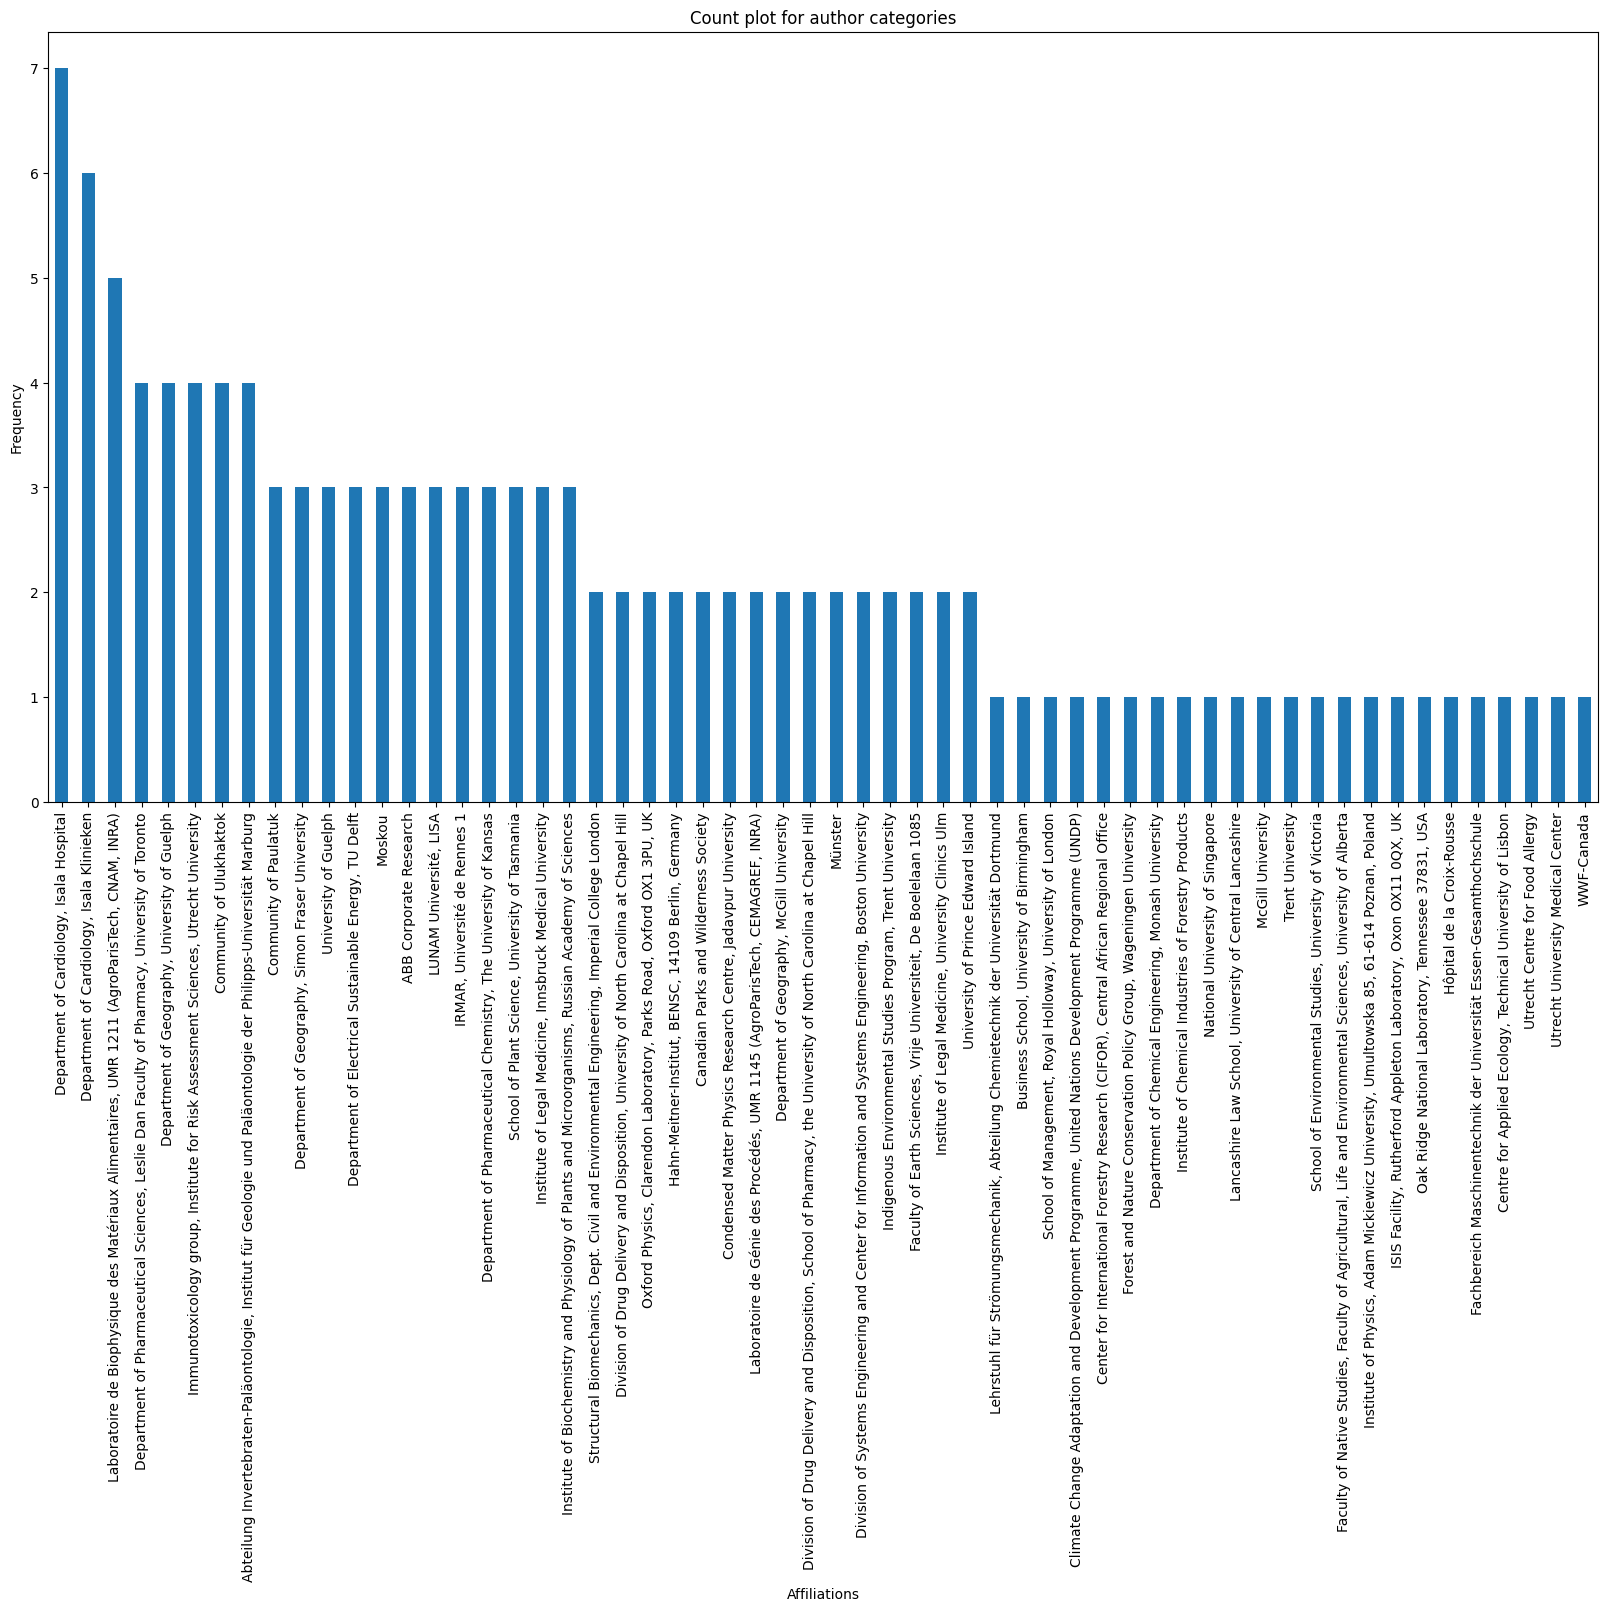

In [6]:
# count plot for product categories
df_all['Affiliations'].value_counts().plot(kind='bar',figsize=[20,10],
                                             xlabel='Affiliations',
                                       ylabel='Frequency', title='Count plot for author categories')

<Axes: title={'center': 'Count plot for author categories'}, xlabel='Authors', ylabel='Frequency'>

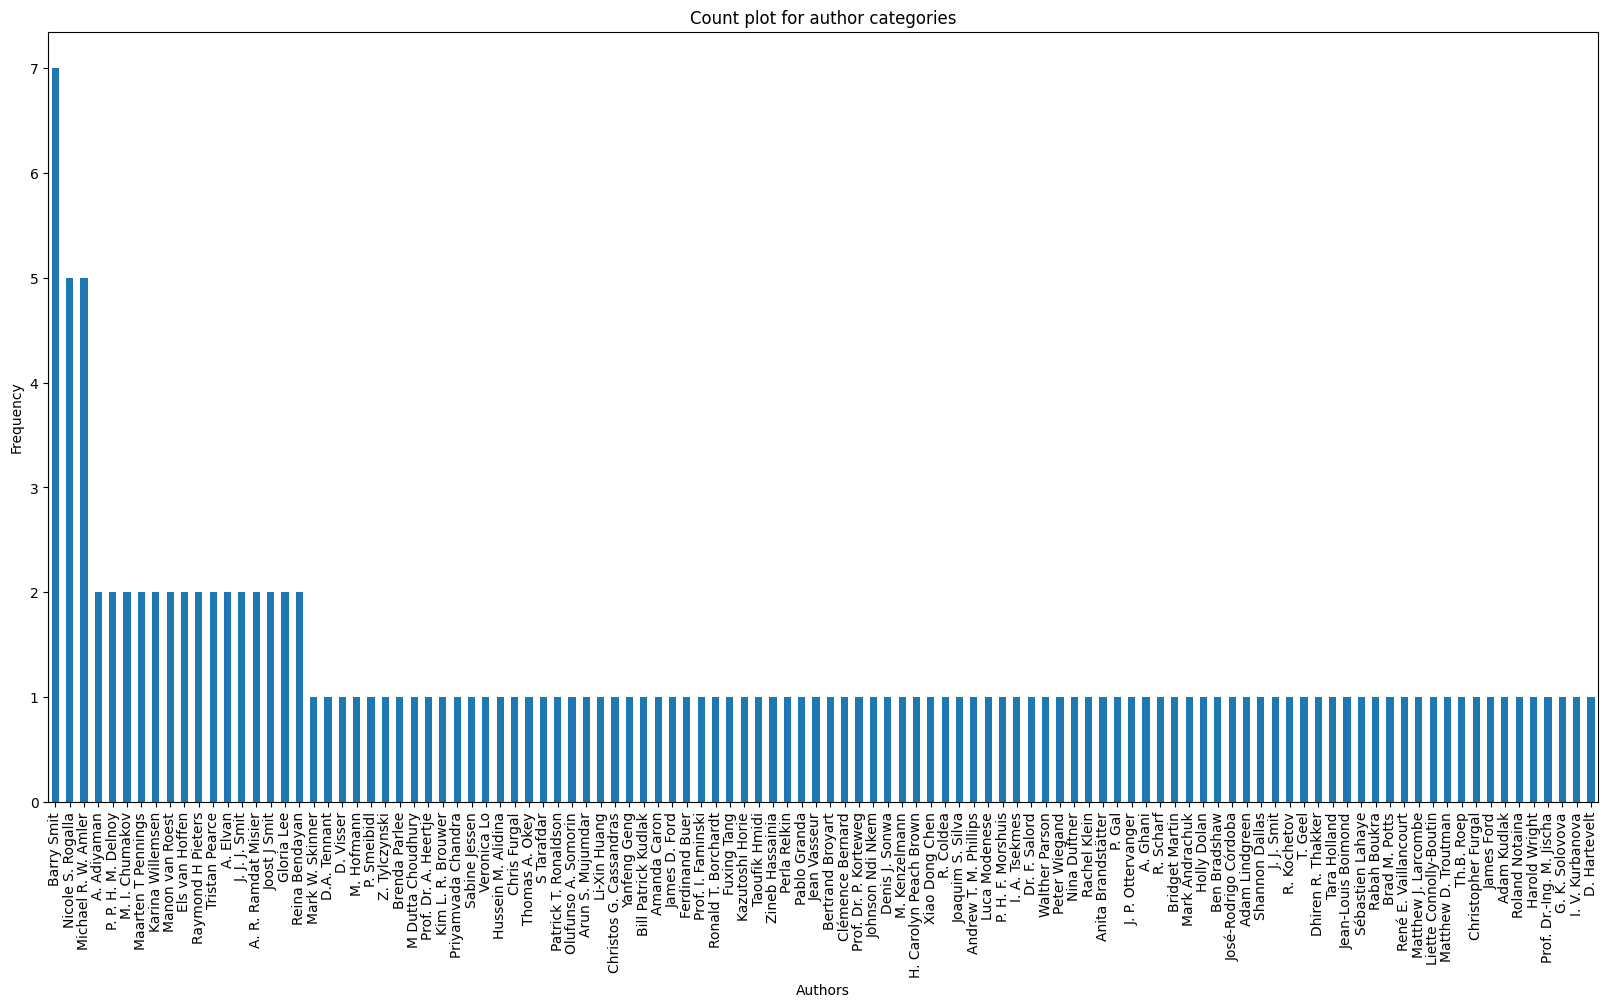

In [7]:
# count plot for product categories
import matplotlib.pyplot as plt
df_all['Author'].value_counts().plot(kind='bar',figsize=[20,10],
                                             xlabel='Authors',
                                       ylabel='Frequency', title='Count plot for author categories')

In [9]:
df_all.isna().sum()

Author              0
ArticleID           0
Article Title       0
Journal Title       0
Journal Subject     0
Affiliations       10
dtype: int64

In [16]:
df_all.nunique()

Author             108
ArticleID           47
Article Title       47
Journal Title       29
Journal Subject     16
Affiliations        59
dtype: int64

In [10]:
df_all = df_all.fillna("NA")

### Disambiguating similar named authors by grouping

In [15]:
# grouping by author and affiliations 
df_all.groupby(by=['Author', 'Affiliations'], 
               as_index=False)['ArticleID'].count().sort_values(by='Author', ascending=True)

,Author,Affiliations,ArticleID
0,A. Adiyaman,"Department of Cardiology, Isala Hospital",1
1,A. Adiyaman,"Department of Cardiology, Isala Klinieken",1
2,A. Elvan,"Department of Cardiology, Isala Hospital",1
3,A. Elvan,"Department of Cardiology, Isala Klinieken",1
4,A. Ghani,"Department of Cardiology, Isala Hospital",1
...,...,...,...
129,Walther Parson,"Institute of Legal Medicine, Innsbruck Medical...",1
130,Xiao Dong Chen,"Department of Chemical Engineering, Monash Uni...",1
131,Yanfeng Geng,Division of Systems Engineering and Center for...,1
132,Z. Tylczynski,"Institute of Physics, Adam Mickiewicz Universi...",1


In [13]:
df_all.groupby(by=['Affiliations', 'Author'], dropna=True,
               as_index=False)['ArticleID'].count().sort_values(by='ArticleID', ascending=False)

,Affiliations,Author,ArticleID
42,"Department of Geography, University of Guelph",Barry Smit,2
3,"Abteilung Invertebraten-Paläontologie, Institu...",Michael R. W. Amler,2
4,"Abteilung Invertebraten-Paläontologie, Institu...",Nicole S. Rogalla,2
94,"Laboratoire de Génie des Procédés, UMR 1145 (A...",Bertrand Broyart,1
88,"LUNAM Université, LISA",Sébastien Lahaye,1
...,...,...,...
40,"Department of Geography, Simon Fraser University",Ben Bradshaw,1
39,"Department of Geography, Simon Fraser University",Barry Smit,1
38,"Department of Geography, McGill University",James D. Ford,1
37,"Department of Geography, McGill University",Amanda Caron,1


In [50]:
# Barry Smit 
df_all[df_all['Author']== 'Barry Smit']

,Author,ArticleID,Article Title,Journal Title,Journal Subject,Affiliations
20,Barry Smit,10.1007/s10584-004-0710-z,Farm-Level Adaptation to Climatic Variability ...,Climatic Change,Geosciences,"Department of Geography, Simon Fraser University"
21,Barry Smit,10.1007/s10113-012-0299-0,Community-based vulnerability assessment of Tu...,Regional Environmental Change,Environment,University of Guelph
22,Barry Smit,10.1007/s10745-011-9403-1,Transmission of Environmental Knowledge and La...,Human Ecology,"Social Sciences, general",Community of Ulukhaktok
23,Barry Smit,10.1007/s10113-015-0761-x,"Climate change, food security, and livelihoods...",Regional Environmental Change,Environment,"Department of Geography, University of Guelph"
24,Barry Smit,10.1007/s10113-013-0555-y,Recent climate change in the Prince Edward Cou...,Regional Environmental Change,Environment,"Department of Geography, University of Guelph"
25,Barry Smit,10.1023/A:1015862228270,Adaptation options in agriculture to climate c...,Mitigation and Adaptation Strategies for Globa...,Geosciences,"Indigenous Environmental Studies Program, Tren..."
26,Barry Smit,10.1007/s13280-014-0493-z,Climate Change and Forest Communities: Prospec...,AMBIO,Environment,University of Prince Edward Island


##### We find out that there are 5 different persons with the name 'Barry Smit'

### Considering the problem as multi class classification to whether a given article belongs to an author

In [19]:
def main():
    input_data = load_data_csv(dir_path+'authors.csv', delimiter=',')
    X_train, y_train, X_test, y_test = preprocess_dataset(input_data)
    # getting all the implemented ml models
    models = get_ml_models()
    # getting the predictions for both the training and testing datasets
    batch_prediction(X_train, y_train, X_test, y_test, models)

Columns in the data frame Index(['Author', 'ArticleID', 'Article Title', 'Journal Title',
       'Journal Subject', 'Affiliations'],
      dtype='object')
Input dataframe shape (137, 6)
folder ./results already exists
folder ./results already exists
Saving predictions
Average Training accuracy for LR is 65.974 (0.018)
Average Validation accuracy for LR is 3.377 (0.036)
Average Training F1 score for LR is 0.568 (0.022)
Average Validation F1-score for LR is 0.021 (0.024)
Test accuracy for LR is 0.000
Test Precision for LR is 0.000000
Test Recall for LR is 0.000
Test F1-score for LR is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
             adiyaman       0.00      0.00      0.00       1.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak    

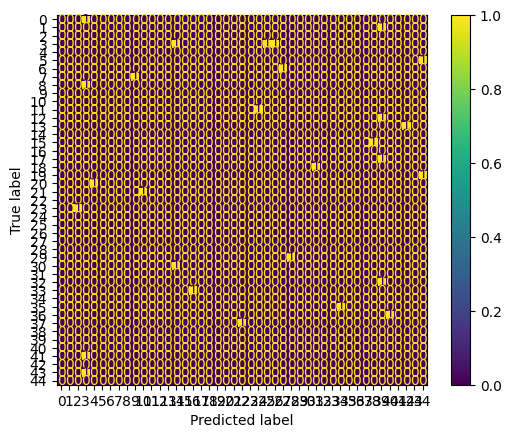

-------------------------------------------------
Saving predictions
Average Training accuracy for MultiNaiveBayes is 66.281 (0.020)
Average Validation accuracy for MultiNaiveBayes is 2.756 (0.028)
Average Training F1 score for MultiNaiveBayes is 0.594 (0.025)
Average Validation F1-score for MultiNaiveBayes is 0.020 (0.021)
Test accuracy for MultiNaiveBayes is 0.000
Test Precision for MultiNaiveBayes is 0.000000
Test Recall for MultiNaiveBayes is 0.000
Test F1-score for MultiNaiveBayes is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
       adam lindgreen       0.00      0.00      0.00       0.0
             adiyaman       0.00      0.00      0.00       1.0
         amanda caron       0.00      0.00      0.00       0.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00      

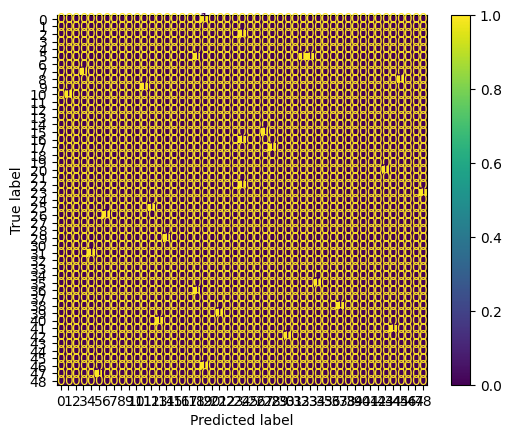

-------------------------------------------------
Saving predictions
Average Training accuracy for SVM is 66.281 (0.020)
Average Validation accuracy for SVM is 2.756 (0.028)
Average Training F1 score for SVM is 0.594 (0.025)
Average Validation F1-score for SVM is 0.020 (0.021)
Test accuracy for SVM is 0.000
Test Precision for SVM is 0.000000
Test Recall for SVM is 0.000
Test F1-score for SVM is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
       adam lindgreen       0.00      0.00      0.00       0.0
             adiyaman       0.00      0.00      0.00       1.0
         amanda caron       0.00      0.00      0.00       0.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak       0.00      0.00      0.00       1.0
           brad potts       

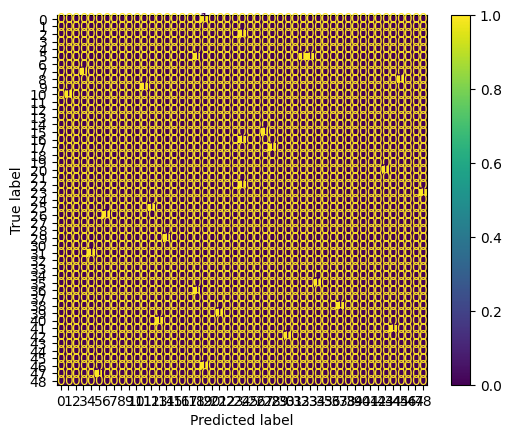

-------------------------------------------------
Saving predictions
Average Training accuracy for Perceptron is 60.165 (0.021)
Average Validation accuracy for Perceptron is 1.530 (0.027)
Average Training F1 score for Perceptron is 0.536 (0.022)
Average Validation F1-score for Perceptron is 0.009 (0.016)
Test accuracy for Perceptron is 3.571
Test Precision for Perceptron is 0.035714
Test Recall for Perceptron is 0.036
Test F1-score for Perceptron is 0.036
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00         1
             adiyaman       0.00      0.00      0.00         1
      andrew phillips       0.00      0.00      0.00         0
           barry smit       0.00      0.00      0.00         3
     bertrand broyart       0.00      0.00      0.00         0
  bill patrick kudlak       0.00      0.00      0.00         1
           brad potts       0.00      0.00      0.00         1
        brenda parlee       0.00   

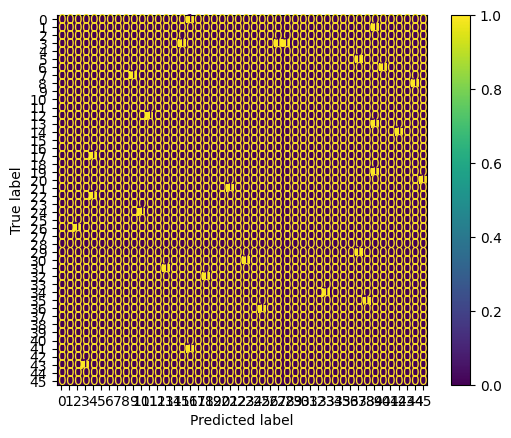

-------------------------------------------------
Saving predictions
Average Training accuracy for CART is 66.281 (0.020)
Average Validation accuracy for CART is 2.453 (0.028)
Average Training F1 score for CART is 0.592 (0.024)
Average Validation F1-score for CART is 0.017 (0.021)
Test accuracy for CART is 0.000
Test Precision for CART is 0.000000
Test Recall for CART is 0.000
Test F1-score for CART is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
             adiyaman       0.00      0.00      0.00       1.0
         amanda caron       0.00      0.00      0.00       0.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak       0.00      0.00      0.00       1.0
           brad potts       0.00      0.00      0.00       1.0
        brenda parle

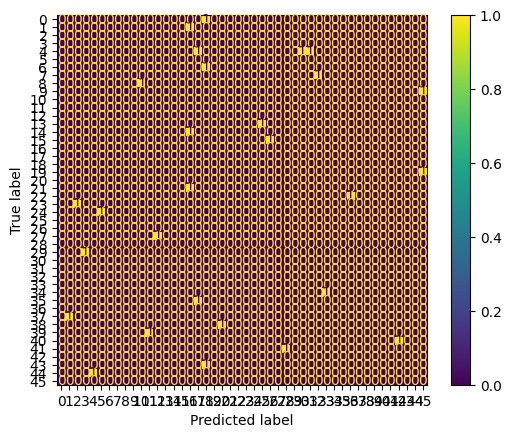

-------------------------------------------------
Saving predictions
Average Training accuracy for RandomForest is 66.281 (0.020)
Average Validation accuracy for RandomForest is 2.453 (0.033)
Average Training F1 score for RandomForest is 0.593 (0.024)
Average Validation F1-score for RandomForest is 0.013 (0.017)
Test accuracy for RandomForest is 0.000
Test Precision for RandomForest is 0.000000
Test Recall for RandomForest is 0.000
Test F1-score for RandomForest is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
             adiyaman       0.00      0.00      0.00       1.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak       0.00      0.00      0.00       1.0
           brad potts       0.00      0.00      0.00       1.0
        brenda parl

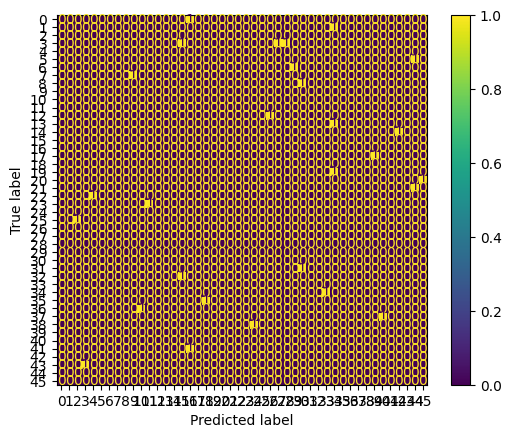

-------------------------------------------------
Saving predictions
Average Training accuracy for GBM is 66.281 (0.020)
Average Validation accuracy for GBM is 1.212 (0.020)
Average Training F1 score for GBM is 0.591 (0.025)
Average Validation F1-score for GBM is 0.010 (0.017)
Test accuracy for GBM is 3.571
Test Precision for GBM is 0.035714
Test Recall for GBM is 0.036
Test F1-score for GBM is 0.036
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00         1
       adam lindgreen       0.00      0.00      0.00         0
             adiyaman       0.00      0.00      0.00         1
      andrew phillips       0.00      0.00      0.00         0
           barry smit       0.00      0.00      0.00         3
     bertrand broyart       0.00      0.00      0.00         0
  bill patrick kudlak       0.00      0.00      0.00         1
           brad potts       0.00      0.00      0.00         1
        brenda parlee       

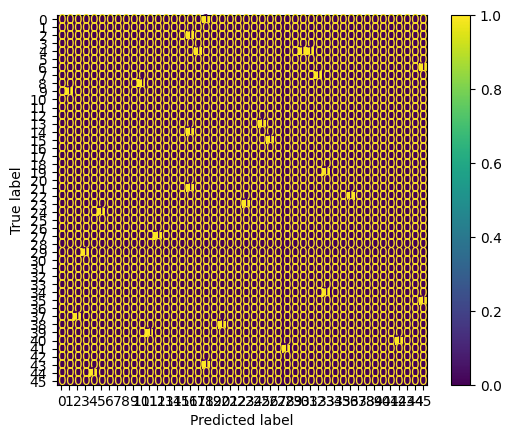

-------------------------------------------------
Saving predictions
Average Training accuracy for MLP is 6.119 (0.093)
Average Validation accuracy for MLP is 0.620 (0.016)
Average Training F1 score for MLP is 0.032 (0.067)
Average Validation F1-score for MLP is 0.004 (0.009)
Test accuracy for MLP is 0.000
Test Precision for MLP is 0.000000
Test Recall for MLP is 0.000
Test F1-score for MLP is 0.000
                     precision    recall  f1-score   support

        adam kudlak       0.00      0.00      0.00       1.0
     adam lindgreen       0.00      0.00      0.00       0.0
           adiyaman       0.00      0.00      0.00       1.0
         barry smit       0.00      0.00      0.00       3.0
bill patrick kudlak       0.00      0.00      0.00       1.0
         brad potts       0.00      0.00      0.00       1.0
      brenda parlee       0.00      0.00      0.00       1.0
     bridget martin       0.00      0.00      0.00       1.0
     els van hoffen       0.00      0.00      0

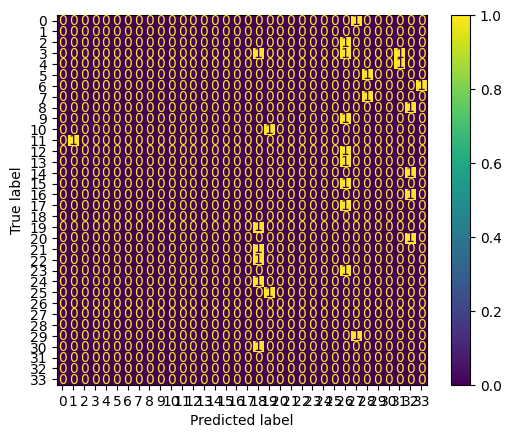

-------------------------------------------------


In [20]:
main()

Columns in the data frame Index(['Author', 'ArticleID', 'Article Title', 'Journal Title',
       'Journal Subject', 'Affiliations'],
      dtype='object')
Input dataframe shape (137, 6)
folder ./results already exists
folder ./results already exists
Saving predictions
Average Training accuracy for LR is 65.974 (0.018)
Average Validation accuracy for LR is 3.377 (0.036)
Average Training F1 score for LR is 0.568 (0.022)
Average Validation F1-score for LR is 0.021 (0.024)
Test accuracy for LR is 0.000
Test Precision for LR is 0.000000
Test Recall for LR is 0.000
Test F1-score for LR is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
             adiyaman       0.00      0.00      0.00       1.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak    

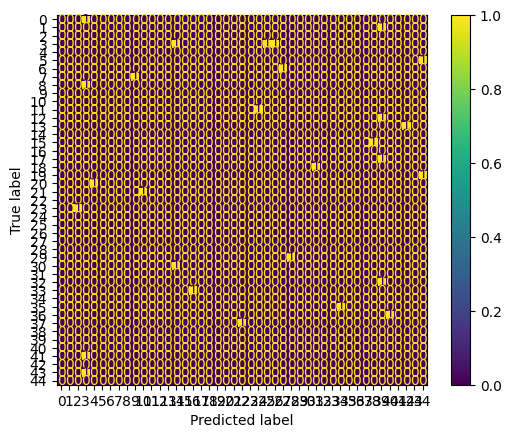

-------------------------------------------------
Saving predictions
Average Training accuracy for MultiNaiveBayes is 66.281 (0.020)
Average Validation accuracy for MultiNaiveBayes is 2.756 (0.028)
Average Training F1 score for MultiNaiveBayes is 0.594 (0.025)
Average Validation F1-score for MultiNaiveBayes is 0.020 (0.021)
Test accuracy for MultiNaiveBayes is 0.000
Test Precision for MultiNaiveBayes is 0.000000
Test Recall for MultiNaiveBayes is 0.000
Test F1-score for MultiNaiveBayes is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
       adam lindgreen       0.00      0.00      0.00       0.0
             adiyaman       0.00      0.00      0.00       1.0
         amanda caron       0.00      0.00      0.00       0.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00      

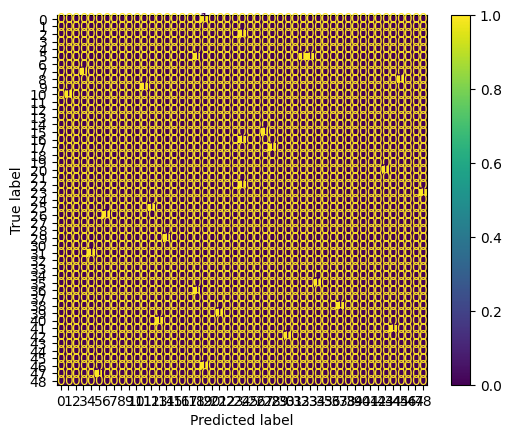

-------------------------------------------------
Saving predictions
Average Training accuracy for SVM is 66.281 (0.020)
Average Validation accuracy for SVM is 2.756 (0.028)
Average Training F1 score for SVM is 0.594 (0.025)
Average Validation F1-score for SVM is 0.020 (0.021)
Test accuracy for SVM is 0.000
Test Precision for SVM is 0.000000
Test Recall for SVM is 0.000
Test F1-score for SVM is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
       adam lindgreen       0.00      0.00      0.00       0.0
             adiyaman       0.00      0.00      0.00       1.0
         amanda caron       0.00      0.00      0.00       0.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak       0.00      0.00      0.00       1.0
           brad potts       

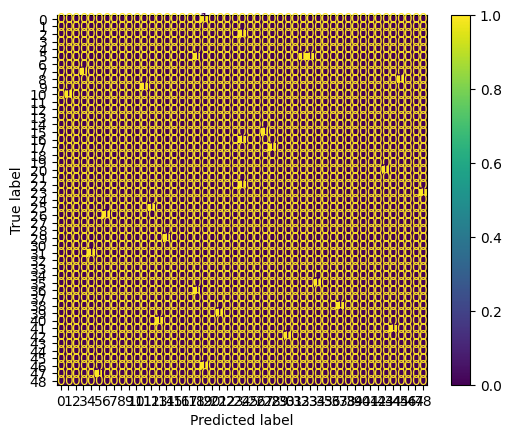

-------------------------------------------------
Saving predictions
Average Training accuracy for Perceptron is 60.165 (0.021)
Average Validation accuracy for Perceptron is 1.530 (0.027)
Average Training F1 score for Perceptron is 0.536 (0.022)
Average Validation F1-score for Perceptron is 0.009 (0.016)
Test accuracy for Perceptron is 3.571
Test Precision for Perceptron is 0.035714
Test Recall for Perceptron is 0.036
Test F1-score for Perceptron is 0.036
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00         1
             adiyaman       0.00      0.00      0.00         1
      andrew phillips       0.00      0.00      0.00         0
           barry smit       0.00      0.00      0.00         3
     bertrand broyart       0.00      0.00      0.00         0
  bill patrick kudlak       0.00      0.00      0.00         1
           brad potts       0.00      0.00      0.00         1
        brenda parlee       0.00   

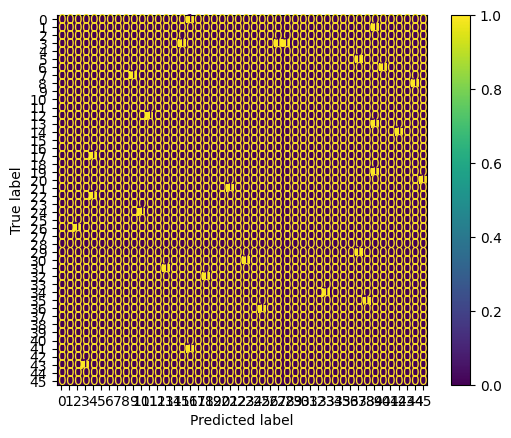

-------------------------------------------------
Saving predictions
Average Training accuracy for CART is 66.281 (0.020)
Average Validation accuracy for CART is 2.453 (0.028)
Average Training F1 score for CART is 0.592 (0.024)
Average Validation F1-score for CART is 0.017 (0.021)
Test accuracy for CART is 0.000
Test Precision for CART is 0.000000
Test Recall for CART is 0.000
Test F1-score for CART is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
             adiyaman       0.00      0.00      0.00       1.0
         amanda caron       0.00      0.00      0.00       0.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak       0.00      0.00      0.00       1.0
           brad potts       0.00      0.00      0.00       1.0
        brenda parle

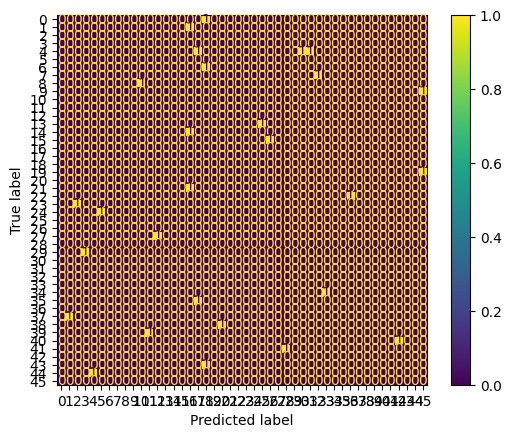

-------------------------------------------------
Saving predictions
Average Training accuracy for RandomForest is 66.281 (0.020)
Average Validation accuracy for RandomForest is 2.453 (0.033)
Average Training F1 score for RandomForest is 0.593 (0.024)
Average Validation F1-score for RandomForest is 0.013 (0.017)
Test accuracy for RandomForest is 0.000
Test Precision for RandomForest is 0.000000
Test Recall for RandomForest is 0.000
Test F1-score for RandomForest is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
             adiyaman       0.00      0.00      0.00       1.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak       0.00      0.00      0.00       1.0
           brad potts       0.00      0.00      0.00       1.0
        brenda parl

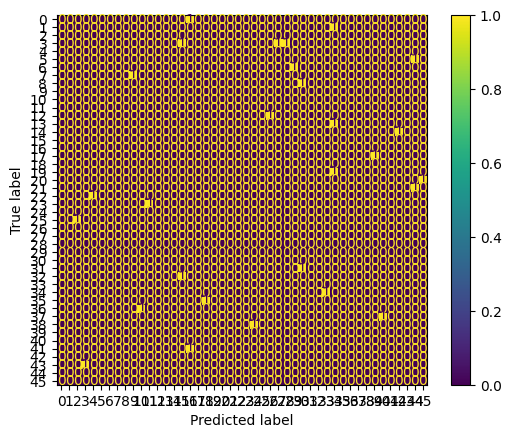

-------------------------------------------------
Saving predictions
Average Training accuracy for GBM is 66.281 (0.020)
Average Validation accuracy for GBM is 1.833 (0.028)
Average Training F1 score for GBM is 0.591 (0.025)
Average Validation F1-score for GBM is 0.015 (0.022)
Test accuracy for GBM is 0.000
Test Precision for GBM is 0.000000
Test Recall for GBM is 0.000
Test F1-score for GBM is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
             adiyaman       0.00      0.00      0.00       1.0
         amanda caron       0.00      0.00      0.00       0.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak       0.00      0.00      0.00       1.0
           brad potts       0.00      0.00      0.00       1.0
        brenda parlee       

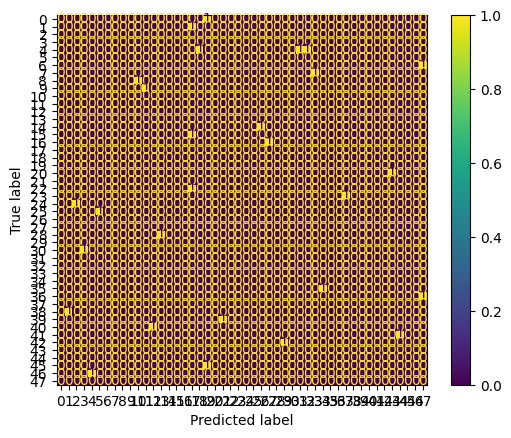

-------------------------------------------------
Saving predictions
Average Training accuracy for MLP is 6.119 (0.093)
Average Validation accuracy for MLP is 0.620 (0.016)
Average Training F1 score for MLP is 0.032 (0.067)
Average Validation F1-score for MLP is 0.004 (0.009)
Test accuracy for MLP is 0.000
Test Precision for MLP is 0.000000
Test Recall for MLP is 0.000
Test F1-score for MLP is 0.000
                     precision    recall  f1-score   support

        adam kudlak       0.00      0.00      0.00       1.0
     adam lindgreen       0.00      0.00      0.00       0.0
           adiyaman       0.00      0.00      0.00       1.0
         barry smit       0.00      0.00      0.00       3.0
bill patrick kudlak       0.00      0.00      0.00       1.0
         brad potts       0.00      0.00      0.00       1.0
      brenda parlee       0.00      0.00      0.00       1.0
     bridget martin       0.00      0.00      0.00       1.0
     els van hoffen       0.00      0.00      0

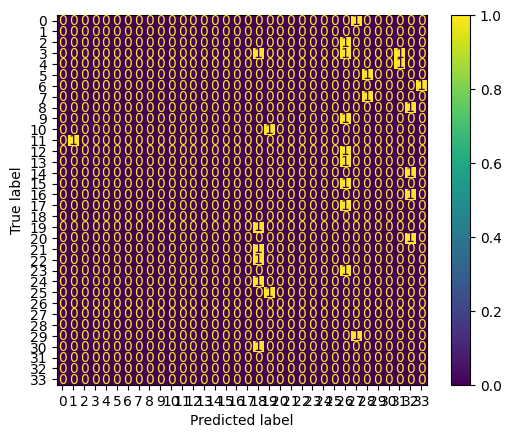

-------------------------------------------------


In [22]:
# after standardizing author names
main()

Columns in the data frame Index(['Author', 'ArticleID', 'Article Title', 'Journal Title',
       'Journal Subject', 'Affiliations'],
      dtype='object')
Input dataframe shape (137, 6)
folder ./results already exists
folder ./results already exists
Saving predictions
Average Training accuracy for LR is 65.974 (0.018)
Average Validation accuracy for LR is 3.377 (0.036)
Average Training F1 score for LR is 0.568 (0.022)
Average Validation F1-score for LR is 0.021 (0.024)
Test accuracy for LR is 0.000
Test Precision for LR is 0.000000
Test Recall for LR is 0.000
Test F1-score for LR is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
             adiyaman       0.00      0.00      0.00       1.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak    

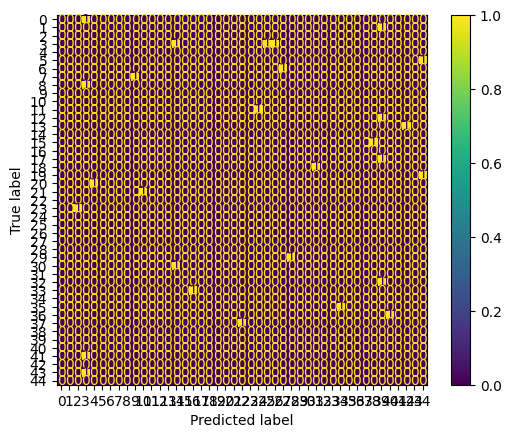

-------------------------------------------------
Saving predictions
Average Training accuracy for MultiNaiveBayes is 66.281 (0.020)
Average Validation accuracy for MultiNaiveBayes is 2.756 (0.028)
Average Training F1 score for MultiNaiveBayes is 0.594 (0.025)
Average Validation F1-score for MultiNaiveBayes is 0.020 (0.021)
Test accuracy for MultiNaiveBayes is 0.000
Test Precision for MultiNaiveBayes is 0.000000
Test Recall for MultiNaiveBayes is 0.000
Test F1-score for MultiNaiveBayes is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
       adam lindgreen       0.00      0.00      0.00       0.0
             adiyaman       0.00      0.00      0.00       1.0
         amanda caron       0.00      0.00      0.00       0.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00      

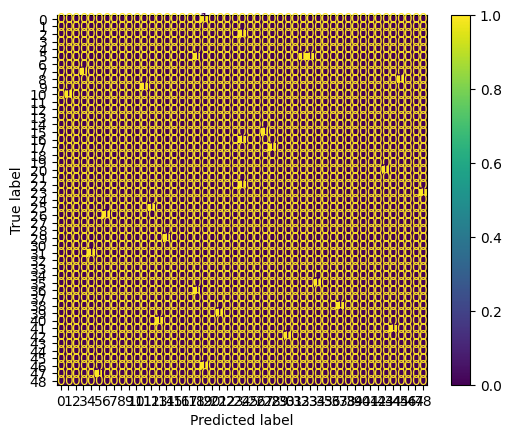

-------------------------------------------------
Saving predictions
Average Training accuracy for SVM is 66.281 (0.020)
Average Validation accuracy for SVM is 2.756 (0.028)
Average Training F1 score for SVM is 0.594 (0.025)
Average Validation F1-score for SVM is 0.020 (0.021)
Test accuracy for SVM is 0.000
Test Precision for SVM is 0.000000
Test Recall for SVM is 0.000
Test F1-score for SVM is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
       adam lindgreen       0.00      0.00      0.00       0.0
             adiyaman       0.00      0.00      0.00       1.0
         amanda caron       0.00      0.00      0.00       0.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak       0.00      0.00      0.00       1.0
           brad potts       

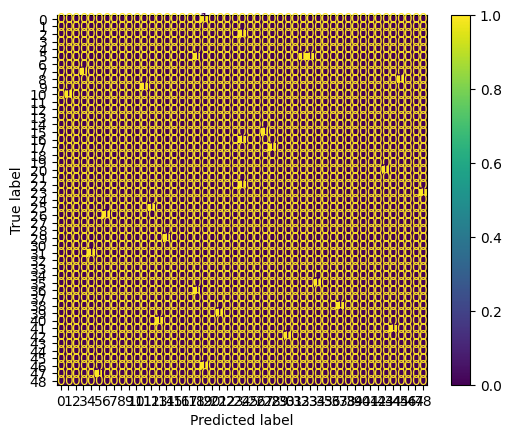

-------------------------------------------------
Saving predictions
Average Training accuracy for Perceptron is 60.165 (0.021)
Average Validation accuracy for Perceptron is 1.530 (0.027)
Average Training F1 score for Perceptron is 0.536 (0.022)
Average Validation F1-score for Perceptron is 0.009 (0.016)
Test accuracy for Perceptron is 3.571
Test Precision for Perceptron is 0.035714
Test Recall for Perceptron is 0.036
Test F1-score for Perceptron is 0.036
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00         1
             adiyaman       0.00      0.00      0.00         1
      andrew phillips       0.00      0.00      0.00         0
           barry smit       0.00      0.00      0.00         3
     bertrand broyart       0.00      0.00      0.00         0
  bill patrick kudlak       0.00      0.00      0.00         1
           brad potts       0.00      0.00      0.00         1
        brenda parlee       0.00   

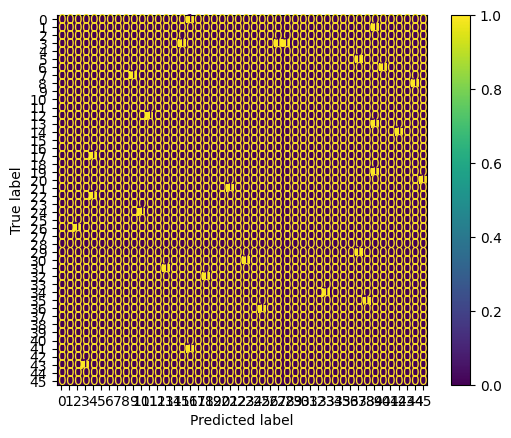

-------------------------------------------------
Saving predictions
Average Training accuracy for CART is 66.281 (0.020)
Average Validation accuracy for CART is 2.453 (0.028)
Average Training F1 score for CART is 0.592 (0.024)
Average Validation F1-score for CART is 0.017 (0.021)
Test accuracy for CART is 0.000
Test Precision for CART is 0.000000
Test Recall for CART is 0.000
Test F1-score for CART is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
             adiyaman       0.00      0.00      0.00       1.0
         amanda caron       0.00      0.00      0.00       0.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak       0.00      0.00      0.00       1.0
           brad potts       0.00      0.00      0.00       1.0
        brenda parle

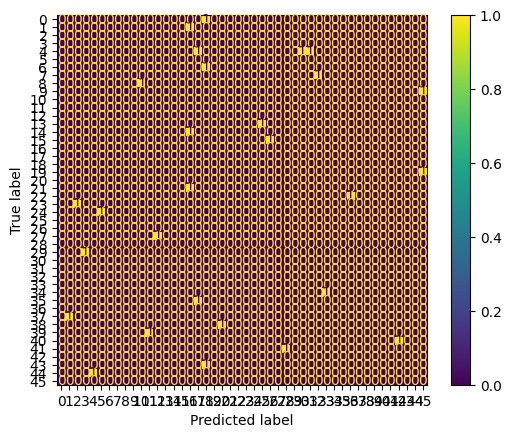

-------------------------------------------------
Saving predictions
Average Training accuracy for RandomForest is 66.281 (0.020)
Average Validation accuracy for RandomForest is 2.453 (0.033)
Average Training F1 score for RandomForest is 0.593 (0.024)
Average Validation F1-score for RandomForest is 0.013 (0.017)
Test accuracy for RandomForest is 0.000
Test Precision for RandomForest is 0.000000
Test Recall for RandomForest is 0.000
Test F1-score for RandomForest is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
             adiyaman       0.00      0.00      0.00       1.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak       0.00      0.00      0.00       1.0
           brad potts       0.00      0.00      0.00       1.0
        brenda parl

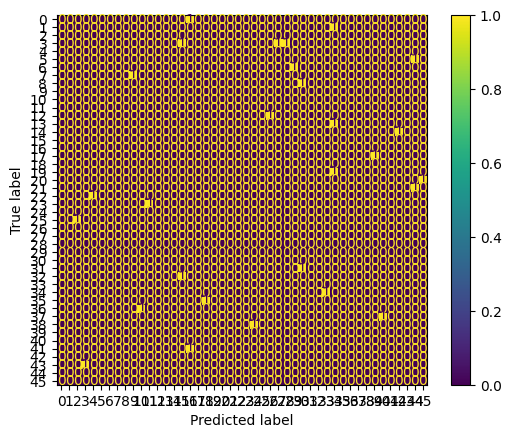

-------------------------------------------------
Saving predictions
Average Training accuracy for GBM is 66.281 (0.020)
Average Validation accuracy for GBM is 1.530 (0.022)
Average Training F1 score for GBM is 0.591 (0.025)
Average Validation F1-score for GBM is 0.013 (0.019)
Test accuracy for GBM is 0.000
Test Precision for GBM is 0.000000
Test Recall for GBM is 0.000
Test F1-score for GBM is 0.000
                       precision    recall  f1-score   support

          adam kudlak       0.00      0.00      0.00       1.0
       adam lindgreen       0.00      0.00      0.00       0.0
             adiyaman       0.00      0.00      0.00       1.0
         amanda caron       0.00      0.00      0.00       0.0
      andrew phillips       0.00      0.00      0.00       0.0
           barry smit       0.00      0.00      0.00       3.0
     bertrand broyart       0.00      0.00      0.00       0.0
  bill patrick kudlak       0.00      0.00      0.00       1.0
           brad potts       

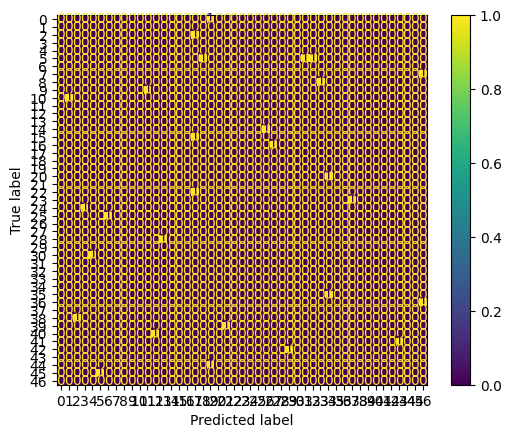

-------------------------------------------------
Saving predictions
Average Training accuracy for MLP is 6.119 (0.093)
Average Validation accuracy for MLP is 0.620 (0.016)
Average Training F1 score for MLP is 0.032 (0.067)
Average Validation F1-score for MLP is 0.004 (0.009)
Test accuracy for MLP is 0.000
Test Precision for MLP is 0.000000
Test Recall for MLP is 0.000
Test F1-score for MLP is 0.000
                     precision    recall  f1-score   support

        adam kudlak       0.00      0.00      0.00       1.0
     adam lindgreen       0.00      0.00      0.00       0.0
           adiyaman       0.00      0.00      0.00       1.0
         barry smit       0.00      0.00      0.00       3.0
bill patrick kudlak       0.00      0.00      0.00       1.0
         brad potts       0.00      0.00      0.00       1.0
      brenda parlee       0.00      0.00      0.00       1.0
     bridget martin       0.00      0.00      0.00       1.0
     els van hoffen       0.00      0.00      0

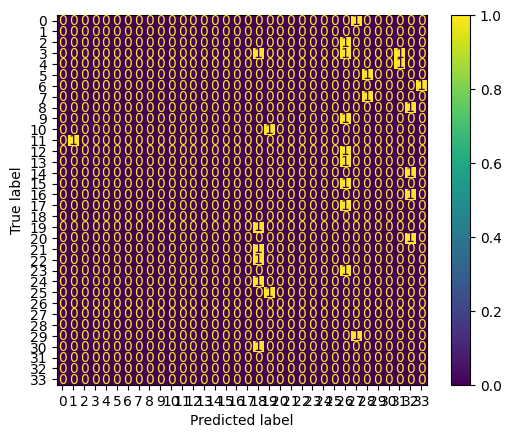

-------------------------------------------------


In [24]:
# after standardizing author names
main()

In [ ]:
def tokenize_text(text):
    # Tokenize text into words
    words = word_tokenize(text)
    return words